# Sport Vouchers Program Analysis
## Zac West - 46163107

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

<ipython-input-3-8c32cb05a179>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [180]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head(500)

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0
ALICE SPRINGS,988.0,988.0,1010.0,1006.0,25181.0
ALPINE,977.0,977.0,970.0,987.0,11891.0
ANANGU PITJANTJATJARA,623.0,623.0,672.0,593.0,2433.0
ARARAT,966.0,966.0,938.0,951.0,11174.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [6]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

<ipython-input-6-8c32cb05a179>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


In [7]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


In [8]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [9]:
def lga_table(data):

    result = pd.DataFrame({'count': data.groupby(['Participant_LGA', 'Voucher_Claim_Year']).size()})

    # join with the population column from the LGA data
    result = result.join(LGA_scores['Population'], on='Participant_LGA')

    result['percent vouchers'] = 100 * result['count'] / result['count'].sum() 
    result['percent_population'] = 100 * result['count'] / result.Population

    return result
    
sa_LGA = lga_table(sa_vouchers_scores)
sa_LGA.sort_values('count', ascending=False).head()

count  Population  percent vouchers  \
Participant_LGA Voucher_Claim_Year                                        
ONKAPARINGA     2016                 5142    159517.0          4.032119   
                2015                 4462    159517.0          3.498894   
SALISBURY       2016                 3388    129067.0          2.656713   
ONKAPARINGA     2017                 3178    159517.0          2.492041   
TEA TREE GULLY  2016                 3065     95461.0          2.403431   

                                    percent_population  
Participant_LGA Voucher_Claim_Year                      
ONKAPARINGA     2016                          3.223481  
                2015                          2.797194  
SALISBURY       2016                          2.624993  
ONKAPARINGA     2017                          1.992264  
TEA TREE GULLY  2016                          3.210735

In [112]:
def sport_table(data):
    
    result = pd.DataFrame({'count': data.groupby(by=['Voucher_Sport', 'Voucher_Claim_Year']).size})
    
    result['percent vouchers'] = 100 * result['count']/result['count'].sum()
    return result

In [ ]:
sa_Sport.xs(2015, level="Voucher_Claim_Year").sort_values('count', accending=False).head()

In [ ]:
sa_Sport.xs(2016, level="Voucher_Claim_Year").sort_values('count', accending=False).head()

# Questions:

## Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 


In [227]:
sa_vouchers_scores.head(500)

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0
5,1000007,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Southern Tigers Basketball Association,Basketball,ONKAPARINGA,FISHER,28/5/15 23:09,2015,996.0,996.0,975.0,993.0,159517.0
6,1000007,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Southern Tigers Basketball Association,Basketball,ONKAPARINGA,FISHER,17/6/16 1:02,2016,996.0,996.0,975.0,993.0,159517.0
7,1000008,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Woods Panthers Netball Club,Netball,ONKAPARINGA,FISHER,19/5/16 1:55,2016,996.0,996.0,975.0,993.0,159517.0
8,1000011,ABERFOYLE PARK,Registered Previously,Not ATSI,CALD,Female,50,Hub Netball Club,Netball,ONKAPARINGA,FISHER,19/5/16 1:48,2016,996.0,996.0,975.0,993.0,159517.0
9,1000011,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,6/8/15 6:13,2015,996.0,996.0,975.0,993.0,159517.0


In [58]:
sa_vouchers_scores.describe()

,Participant_ID,Voucher_Value,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
count,1.275260e+05,127526.000000,127526.000000,118066.000000,118066.000000,118066.000000,118066.000000,118066.000000
mean,1.063764e+06,49.663951,2015.915100,981.049942,981.049942,971.090416,981.756314,68014.296046
std,3.681374e+04,2.700970,0.765087,44.454505,44.454505,56.889280,55.538098,50470.140017
min,1.000002e+06,5.000000,2015.000000,870.000000,870.000000,808.000000,798.000000,871.000000
25%,1.031883e+06,50.000000,2015.000000,955.000000,955.000000,927.000000,937.000000,22070.000000
50%,1.063764e+06,50.000000,2016.000000,974.000000,974.000000,973.000000,987.000000,62912.000000
75%,1.095646e+06,50.000000,2017.000000,1013.000000,1013.000000,997.000000,1018.000000,104922.000000
max,1.127526e+06,50.000000,2017.000000,1083.000000,1083.000000,1090.000000,1096.000000,159517.000000


In [80]:
pd.crosstab(index=sa_vouchers_scores['Voucher_Sport'], columns='count')

col_0,count
Voucher_Sport,
Archery,34
Athletics,4518
Australian Rules,47224
BMX,157
Badminton,4
Baseball,865
Basketball,6016
Bowls,2
Calisthenics,2522


<AxesSubplot:>

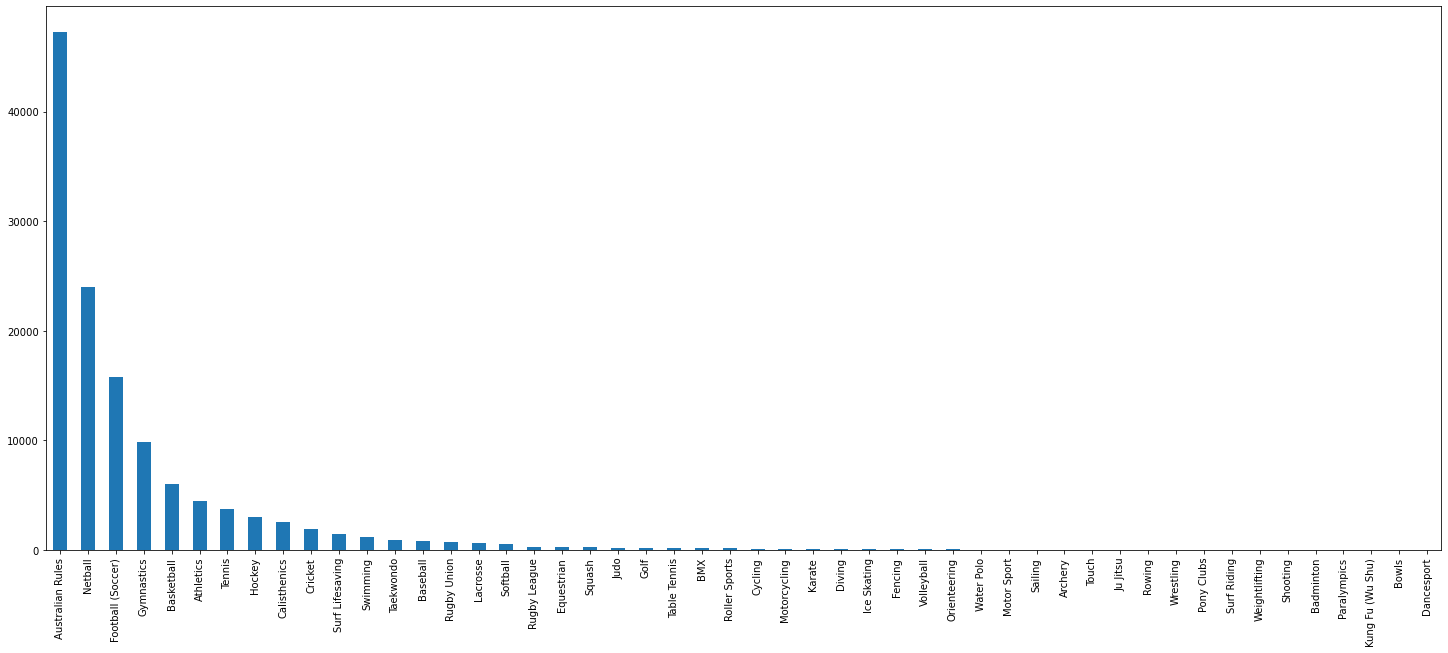

In [56]:
pd.value_counts(sa_vouchers_scores['Voucher_Sport']).plot.bar(figsize=(25, 10))

We can clearly determine that most sport used with the Sport Voucher Program was Australian Rules followed by Netball, Soccer and Gymnastics.

In [70]:
# simplify code
tot_vouch = sa_vouchers_scores['Voucher_Sport'].count()
# values taken from cross table above
print("Australian Rules consisted of " + str((47224/tot_vouch)*100) + " percent of all vouchers used.")
print("Netball consisted of " + str((24017/tot_vouch)*100) + " percent of all vouchers used.")
print("Gymnastics consisted of " + str((9823/tot_vouch)*100) + " percent of all vouchers used.")


Australian Rules consisted of 37.03087997741637 percent of all vouchers used.
Netball consisted of 18.833022285651555 percent of all vouchers used.
Gymnastics consisted of 7.702742970061008 percent of all vouchers used.


In [94]:
pd.set_option('display.max_rows', 500)
pd.crosstab(index=sa_vouchers_scores['Participant_LGA'], columns='count')

col_0,count
Participant_LGA,
ADELAIDE,302
ADELAIDE HILLS,4756
ADELAIDE PLAINS,899
ALEXANDRINA,2979
BAROSSA,2874
BARUNGA WEST,333
BERRI BARMERA,1486
BURNSIDE,2213
CAMPBELLTOWN,2567


<AxesSubplot:>

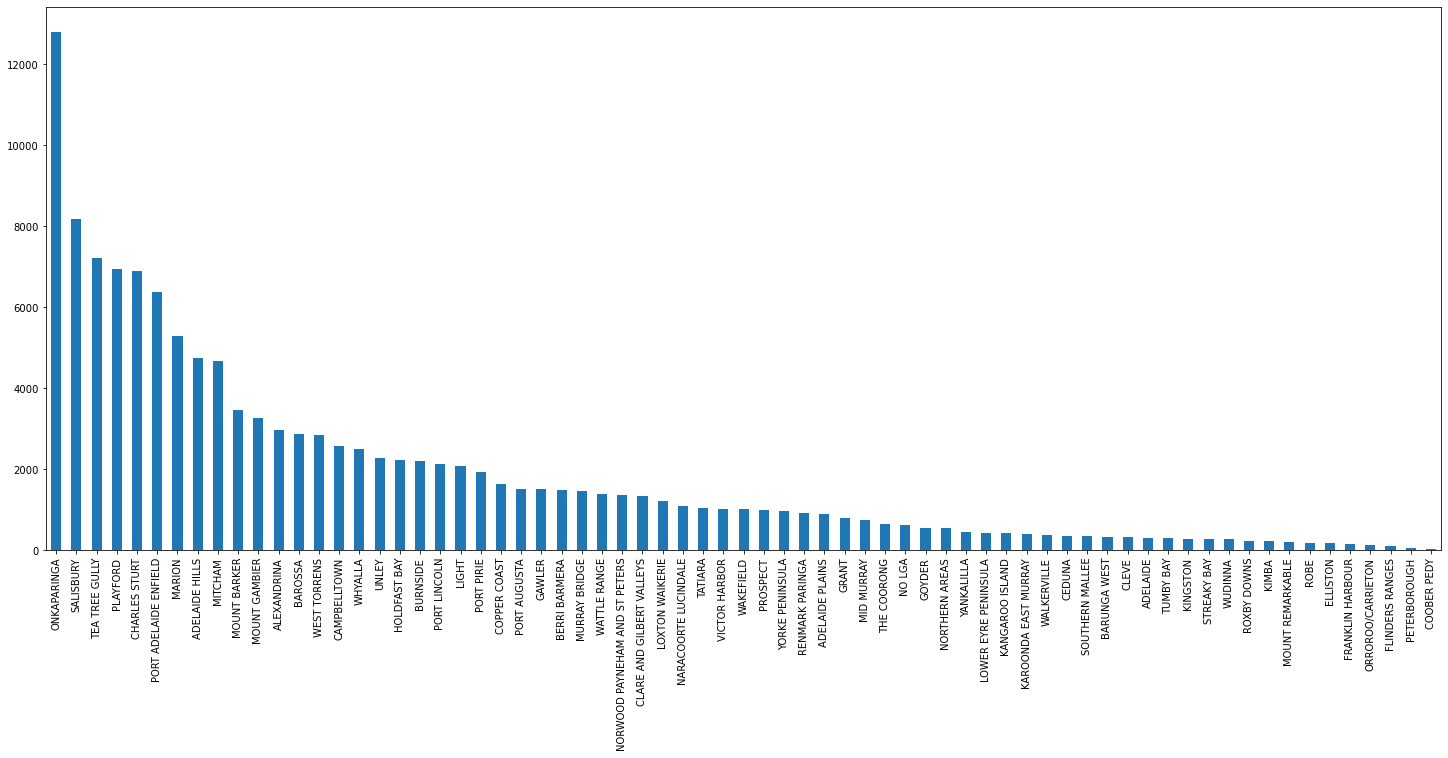

In [85]:
pd.value_counts(sa_vouchers_scores['Participant_LGA']).plot.bar(figsize=(25, 10))

In [104]:
print("From the data above, we can see that the LGA of Onkaparinga had the most vouchers utilised attributing to " + str((12782/tot_vouch)*100) + " percent of all vouchers. Followed by Salisbury with " + str((8169/tot_vouch)*100) + " percent and Tea Tree Gully with " + str((7219/tot_vouch)*100) + " percent.")

From the data above, we can see that the LGA of Onkaparinga had the most vouchers utilised attributing to 10.02305412229663 percent of all vouchers. Followed by Salisbury with 6.405752552420683 percent and Tea Tree Gully with 5.66080642378809 percent.


## Are some sports more popular in different parts of the state

In [303]:
def sport_lga(data):

    result = pd.DataFrame({'count': data.groupby([ 'Participant_LGA', 'Voucher_Sport']).size()})

    # join with the population column from the LGA data
    result = result.join(LGA_scores['Population'], on='Participant_LGA')

    result['percent vouchers'] = 100 * result['count'] / result['count'].sum() 
    result['percent_population'] = 100 * result['count'] / result.Population

    return result
    
sa_sport_lga = sport_lga(sa_vouchers_scores)
sa_sport_lga.sort_values(['Participant_LGA', 'count'], ascending=True).head(500)

count  Population  \
Participant_LGA           Voucher_Sport                          
ADELAIDE                  Baseball               1     19606.0   
                          Calisthenics           1     19606.0   
                          Golf                   1     19606.0   
                          Cricket                2     19606.0   
                          Softball               2     19606.0   
                          Fencing                3     19606.0   
                          Rugby Union            3     19606.0   
                          Basketball             4     19606.0   
                          Judo                   4     19606.0   
                          Tennis                 4     19606.0   
                          Diving                 5     19606.0   
                          Orienteering           6     19606.0   
                          Lacrosse               8     19606.0   
                          Taekwondo             11     19606.0   
                          Surf Lifesaving       14     19606.0   
                          Athletics             16     19606.0   
                          Hockey                17     19606.0   
                          Gymnastics            20     19606.0   
                          Netball               23     19606.0   
                          Football (Soccer)     27     19606.0   
                          Australian Rules     130     19606.0   
ADELAIDE HILLS            Cycling                1     38601.0   
                          Judo                   1     38601.0   
                          Paralympics            1     38601.0   
                          Volleyball             1     38601.0   
                          Water Polo             1     38601.0   
                          BMX                    2     38601.0   
                          Fencing                2     38601.0   
                          Motorcycling           2     38601.0   
                          Touch                  2     38601.0   
                          Archery                3     38601.0   
                          Table Tennis           3     38601.0   
                          Roller Sports          4     38601.0   
                          Surf Lifesaving        5     38601.0   
                          Orienteering           6     38601.0   
                          Diving                 7     38601.0   
                          Pony Clubs             8     38601.0   
                          Equestrian             9     38601.0   
                          Baseball              11     38601.0   
                          Lacrosse              16     38601.0   
                          Swimming              18     38601.0   
                          Softball              27     38601.0   
                          Rugby Union           36     38601.0   
                          Taekwondo             44     38601.0   
                          Basketball            48     38601.0   
                          Hockey                52     38601.0   
                          Calisthenics          62     38601.0   
                          Cricket              128     38601.0   
                          Gymnastics           176     38601.0   
                          Athletics            204     38601.0   
                          Tennis               257     38601.0   
                          Football (Soccer)    812     38601.0   
                          Netball             1395     38601.0   
                          Australian Rules    1412     38601.0   
ADELAIDE PLAINS           Rugby League           1         NaN   
                          Surf Lifesaving        1         NaN   
                          Cycling                2         NaN   
                          Athletics              3         NaN   
                          Baseball               3         NaN   
                   

Yes, some sports are more popular in differnt parts of the state. Although the top sports (Australian Rules, Netball, Soccer and Gymnastics) tended to take out the most amount of vouchers per LGA, there were some exceptions. These exceptions included Franklin Harbour which had almost twice the amount of vouchers used on Swimming than Australian Rules. 

It was clear to see that the most dominant sports based on voucher data, were those which were most accessable. Take the top three most popular sports in this case: Australian Rules, Netball and Soccer. They all are very acessable, requiring little equipment and aren't overly expensive. In addition, they all are played on mostly outdoor pitches and require a ball, all of which are very easy to source. Compaire this to some of the least popular sports: Sailing, Motorsport and Iceskating. Two of which have a high barrier of entry, being that they are very expensive. Iceskating isn't as expensive as Motorsport and Sailing, but their equipment is very hard to source. In addition, all three sports must require very specific played to play (icerings, large bodies of safe water and a Motorsports track). Quite often we saw zero vouchers utilised due to their ability to access these requirements. Areas, however, which suited these sports, such as areas with a track, sailing club or icering, saw elevated numbers of vouchers used. This was the case for the majority of sports. 

In summation, easily accessable, cheep and easy to play sports saw the highest voucher usage whereas, sports that require specific environment and alot of practice to participate in saw lower voucher usage. Additionally, areas with prime conditions and/or accessablility to some sports saw very high usage of vouchers. An example of this is with Port Adelaide Enfield, which saw very high numbers of vouchers used for the sport of Sailing due to its accesability to water, marine equipment and sailing clubs.

## Are any electorates over/under represented in their use of vouchers

<AxesSubplot:>

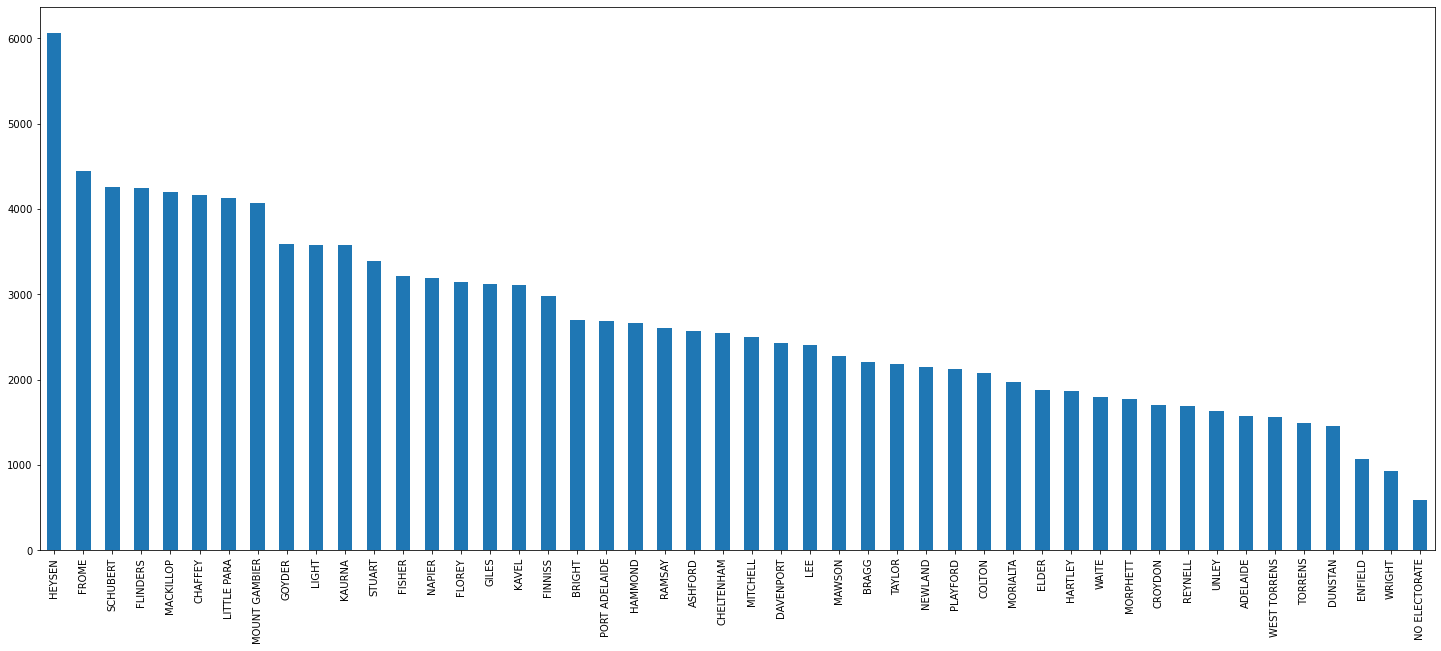

In [263]:
pd.value_counts(sa_vouchers_scores['Participant_Electorate']).plot.bar(figsize=(25, 10))

In [409]:
def sport_Electorate(data):
    
    result = pd.DataFrame({'count': data.groupby([ 'Participant_Electorate']).size()})
    # join with the population column from the LGA data
    result = result.join(LGA_scores['Population'], on='Participant_Electorate')

    result['percent_vouchers'] = 100 * result['count'] / result['count'].sum() 
    result['percent_population'] = 100 * result['count'] / result.Population
    
    result['IEO'] = LGA_scores['IEO']
    result['IER'] = LGA_scores['IER']
    result['IRSAD'] = LGA_scores['IRSAD']
    result['IRSD'] = LGA_scores['IRSD']
    
    return result
    
sa_sport_Electorate = sport_Electorate(sa_vouchers_scores)
sa_sport_Electorate.sort_values(['count'], ascending=False).head(20)

,count,Population,percent_vouchers,percent_population,IEO,IER,IRSAD,IRSD
Participant_Electorate,,,,,,,,
HEYSEN,6066,NaN,4.756677,NaN,NaN,NaN,NaN,NaN
FROME,4445,NaN,3.485564,NaN,NaN,NaN,NaN,NaN
SCHUBERT,4252,NaN,3.334222,NaN,NaN,NaN,NaN,NaN
FLINDERS,4242,1280.5,3.326381,331.276845,963.5,963.5,948.0,957.0
MACKILLOP,4195,NaN,3.289525,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
GILES,3115,NaN,2.442639,NaN,NaN,NaN,NaN,NaN
KAVEL,3103,NaN,2.433229,NaN,NaN,NaN,NaN,NaN
FINNISS,2976,NaN,2.333642,NaN,NaN,NaN,NaN,NaN


In [410]:
sa_sport_Electorate_clean = sa_sport_Electorate.dropna()

<AxesSubplot:xlabel='Participant_Electorate'>

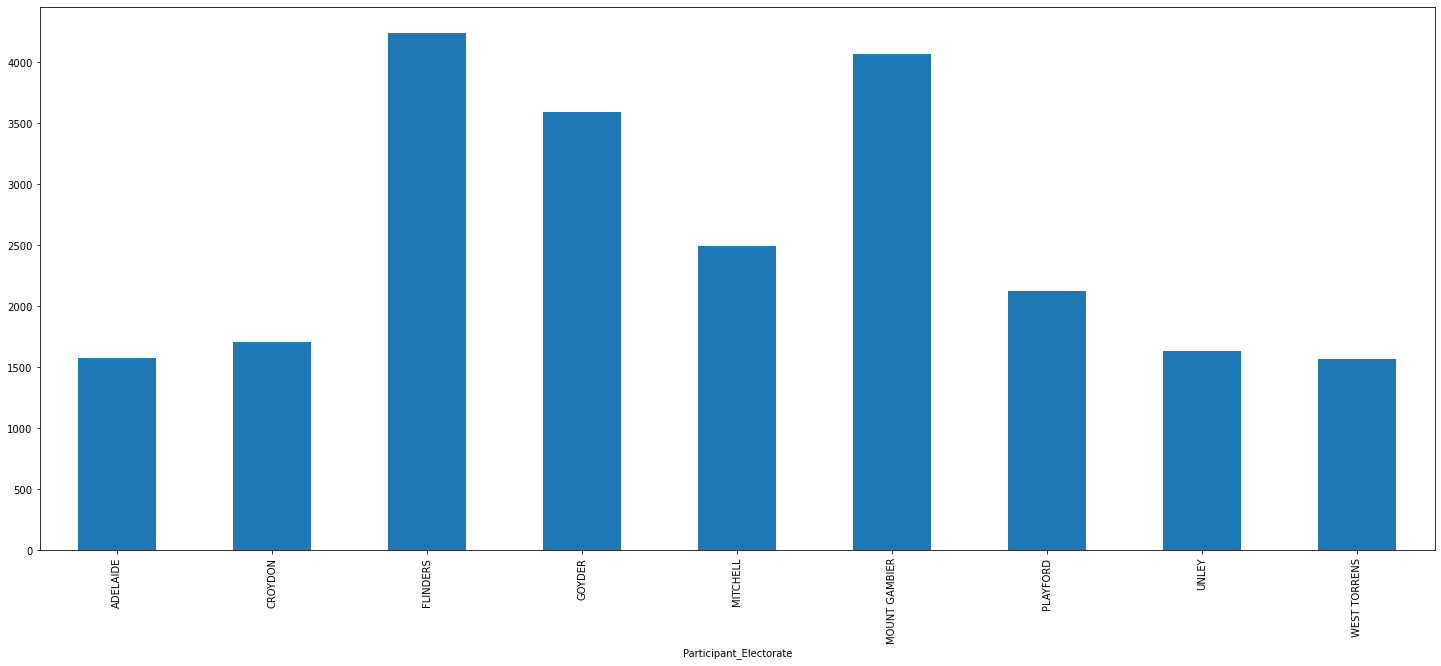

In [411]:
sa_sport_Electorate_clean['count'].plot.bar(figsize=(25, 10))

<AxesSubplot:xlabel='Participant_Electorate'>

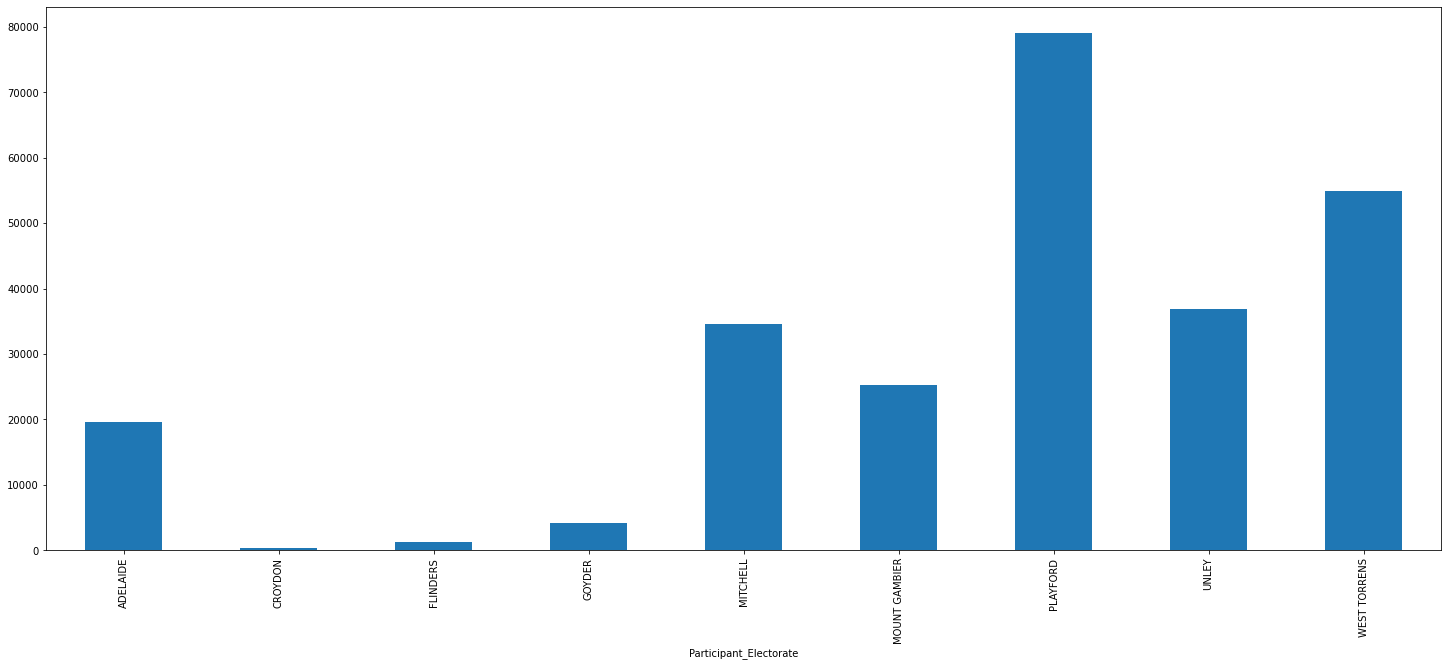

In [412]:
sa_sport_Electorate_clean['Population'].plot.bar(figsize=(25, 10))

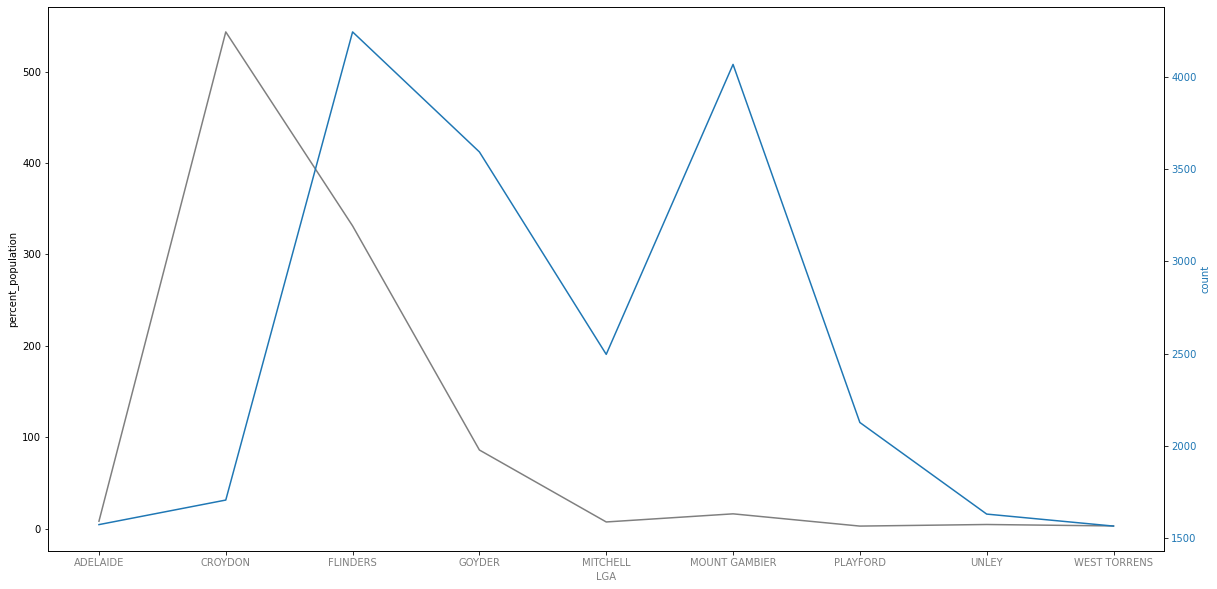

In [415]:
fig, ax1 = plt.subplots()

color = 'tab:grey'
ax1.set_xlabel('LGA', color=color)
ax1.set_ylabel('percent_population')
ax1.plot(sa_sport_Electorate_clean['percent_population'], color=color)
ax1.tick_params(axis='x', labelcolor=color)

IRSADax2 = ax1.twinx()  # instantiate a second axes that shares the same y-axis

color = 'tab:blue'
IRSADax2.set_ylabel('count', color=color)  # we already handled the y-label with ax1
IRSADax2.plot(sa_sport_Electorate_clean['count'], color=color)
IRSADax2.tick_params(axis='y', labelcolor=color)

fig.set_size_inches(20, 10)

Yes, there are certainly some electorates with low or high volumes of voucher usage when compaired to their population. 

Altough we werent left with a high number of electorates with a population data but, it is still enough to point out some findings.

Some electorates such as Adelaide and West Torrens returned low population percentage and low count of vouchers. We also saw some low percent of population with high voucher counts such as Mount Gambier and the opposite with Croydon having high population but low voucher counts. 

From this we can see that the distribution of vouchers isn't linked to the population of electorates. This could have been a result of varying average ages in electorates. For example, an electorate with a high average age wouldn't see as high count of vouchers used when compaired to an electorate with low average age with similar populations. This is because the voucher program specifically targeted kids thus, with areas with high proportions of children would likely see high voucher rates. 

## Is there a relationship between any of the SEIFA measures and voucher use in an LGA

In [419]:
def sport_LGA(data):
    
    result = pd.DataFrame({'count': data.groupby([ 'Participant_LGA']).size()})
    # join with the population column from the LGA data
    result = result.join(LGA_scores['Population'], on='Participant_LGA')

    result['percent_vouchers'] = 100 * result['count'] / result['count'].sum() 
    result['percent_population'] = 100 * result['count'] / result.Population
    
    result['IEO'] = LGA_scores['IEO']
    result['IER'] = LGA_scores['IER']
    result['IRSAD'] = LGA_scores['IRSAD']
    result['IRSD'] = LGA_scores['IRSD']
    
    return result
    
sa_sport_LGA = sport_LGA(sa_vouchers_scores)
sa_sport_LGA.sort_values(['Population'], ascending=False).head(20)

,count,Population,percent_vouchers,percent_population,IEO,IER,IRSAD,IRSD
Participant_LGA,,,,,,,,
ONKAPARINGA,12782,159517.0,10.023054,8.012939,996.0,996.0,975.0,993.0
SALISBURY,8169,129067.0,6.405753,6.329271,960.0,960.0,924.0,937.0
PORT ADELAIDE ENFIELD,6384,112797.0,5.006038,5.659725,921.0,921.0,929.0,930.0
CHARLES STURT,6897,104922.0,5.408309,6.573455,957.0,957.0,971.0,976.0
CAMPBELLTOWN,2567,97060.0,2.012923,2.644756,979.5,979.5,973.0,978.0
...,...,...,...,...,...,...,...,...
MOUNT BARKER,3469,29806.0,2.720230,11.638596,1036.0,1036.0,1021.0,1032.0
MOUNT GAMBIER,3271,25254.0,2.564967,12.952404,931.0,931.0,911.0,927.0
ALEXANDRINA,2979,23693.0,2.335994,12.573334,1000.0,1000.0,969.0,987.0


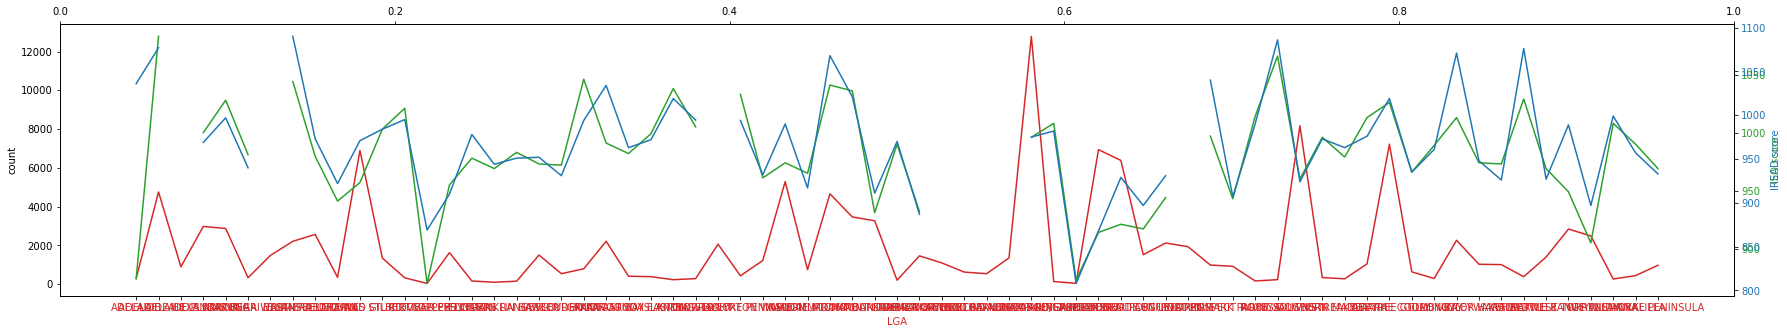

In [420]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('LGA', color=color)
ax1.set_ylabel('count')
ax1.plot(sa_sport_LGA['count'], color=color)
ax1.tick_params(axis='x', labelcolor=color)

IEOax2 = ax1.twinx()  # instantiate a second axes that shares the same y-axis

color = 'tab:green'
IEOax2.set_ylabel('IEO score', color=color)  # we already handled the y-label with ax1
IEOax2.plot(sa_sport_LGA['IEO'], color=color)
IEOax2.tick_params(axis='y', labelcolor=color)

IRSADax2 = IEOax2.twiny()  # instantiate a second axes that shares the same y-axis
IRSADax2 = ax1.twinx()

color = 'tab:blue'
IRSADax2.set_ylabel('IRSAD score', color=color)  # we already handled the y-label with ax1
IRSADax2.plot(sa_sport_LGA['IRSAD'], color=color)
IRSADax2.tick_params(axis='y', labelcolor=color)


fig.set_size_inches(30, 5)

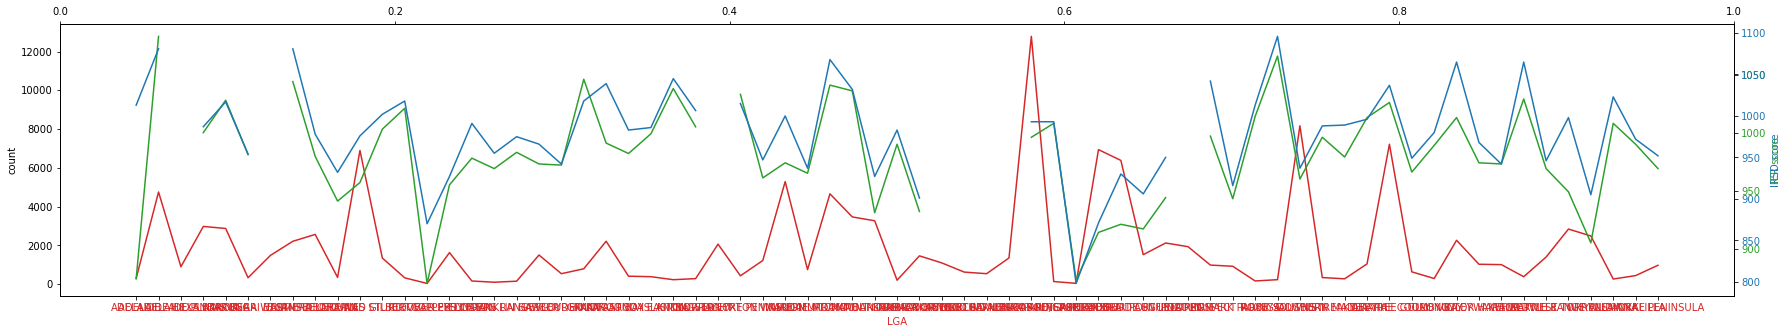

In [421]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('LGA', color=color)
ax1.set_ylabel('count')
ax1.plot(sa_sport_LGA['count'], color=color)
ax1.tick_params(axis='x', labelcolor=color)

IEOax2 = ax1.twinx()  # instantiate a second axes that shares the same y-axis

color = 'tab:green'
IEOax2.set_ylabel('IER score', color=color)  # we already handled the y-label with ax1
IEOax2.plot(sa_sport_LGA['IER'], color=color)
IEOax2.tick_params(axis='y', labelcolor=color)

IRSADax2 = IEOax2.twiny()  # instantiate a second axes that shares the same y-axis
IRSADax2 = ax1.twinx()

color = 'tab:blue'
IRSADax2.set_ylabel('IRSD score', color=color)  # we already handled the y-label with ax1
IRSADax2.plot(sa_sport_LGA['IRSD'], color=color)
IRSADax2.tick_params(axis='y', labelcolor=color)

fig.set_size_inches(30, 5)

Suprisingly there isnt a direct relationship between SEIFA measures and voucher uses in LGAs. 

This could have been linked to more wealthy families tend to have less children, thus having a higher average age than poorer families.

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [226]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head(100)

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00
5,2000007910,NCX1PDN3,8,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Salisbury,150.00
6,2000004074,P4RJYRWF,9,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Caloundra,150.00
7,2000006519,KBWK8ZDS,9,NaN,No,*Other,Wynnum & District Horse & Pony Club Inc,Tingalpa,Brisbane (C),Lytton,Capalaba,150.00
8,2000004081,ERXPFH2D,10,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Caloundra,150.00
9,2000013359,2VWMJK9G,11,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Sippy Downs,150.00


In [225]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-225-d688531e2bfc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
